In [1]:
from Parameters import ModelParams
from Mass_Loss_Class import MassLoss
from Fractionation_Class import Fractionation
from Fractionation_Class_H_O_CO2 import Fractionation_H_O_CO2
from Model_Data_Loader import ModelDataLoader
from Results_Handler import ResultsHandler
from Misc_Class import Misc

import numpy as np

In [2]:
%matplotlib widget


 Running model with FEUV = 100.0 erg/cm^2/s


/Users/mvalatsou/PhD/Repos/Mass-Loss/Mass_Loss_Class.py:96: RuntimeWarning: divide by zero encountered in scalar divide
  diff = (rho_EUV * cs_eq**2 - rho_flow * (u_launch**2 + cs_use**2)) / (2. * rho_EUV * cs_eq**2)
/Users/mvalatsou/PhD/Repos/Mass-Loss/Mass_Loss_Class.py:96: RuntimeWarning: overflow encountered in scalar divide
  diff = (rho_EUV * cs_eq**2 - rho_flow * (u_launch**2 + cs_use**2)) / (2. * rho_EUV * cs_eq**2)


Converged in 2 iterations for planet 0.5 M_earth.
Final mmw_outflow = 1.0
Planet with mass=0.50 M_earth results: Mdot = 3848876.1899376507
Planet with mass=0.50 M_earth results: phi_O = 2.922897464866512e-78, phi_H = 9.09600903319398e-13, x_O = 6.426769046072864e-66

Converged in 2 iterations for planet 1.0 M_earth.
Final mmw_outflow = 1.0
Planet with mass=1.00 M_earth results: Mdot = 3148218.4630707237
Planet with mass=1.00 M_earth results: phi_O = 3.9999057277446448e-84, phi_H = 5.35991084937644e-13, x_O = 1.492526961790786e-71

Converged in 2 iterations for planet 2.0 M_earth.
Final mmw_outflow = 1.0
Planet with mass=2.00 M_earth results: Mdot = 2652801.3708622805
Planet with mass=2.00 M_earth results: phi_O = 1.353800261279639e-89, phi_H = 3.189290517324689e-13, x_O = 8.489664105076658e-77

Converged in 2 iterations for planet 3.0 M_earth.
Final mmw_outflow = 1.0
Planet with mass=3.00 M_earth results: Mdot = 2400225.4871206824
Planet with mass=3.00 M_earth results: phi_O = 9.819953

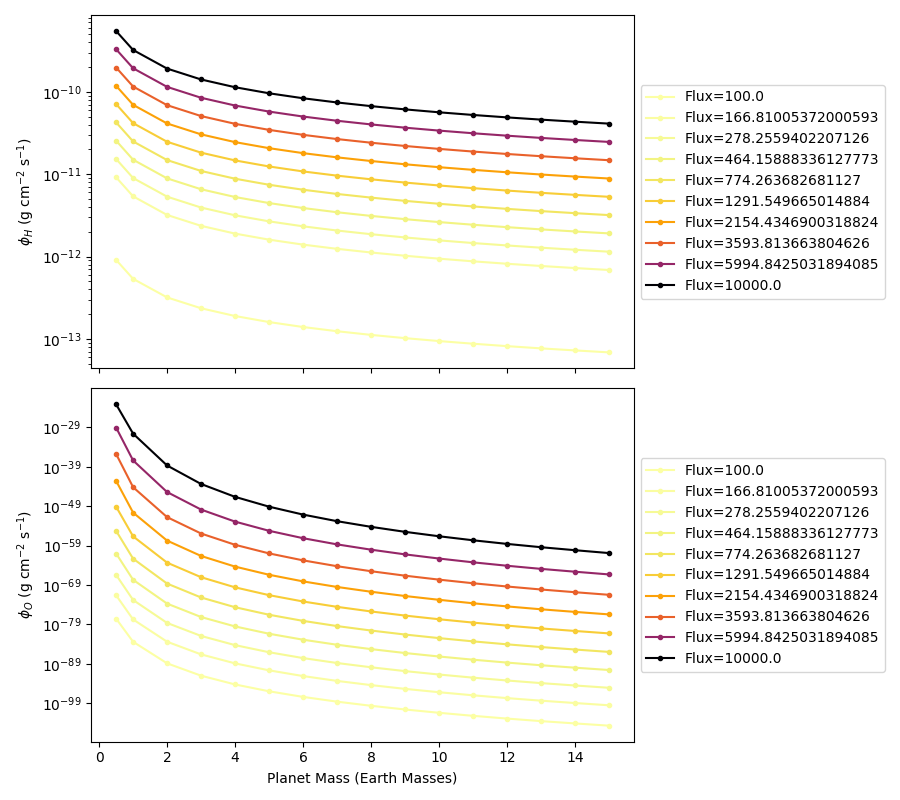

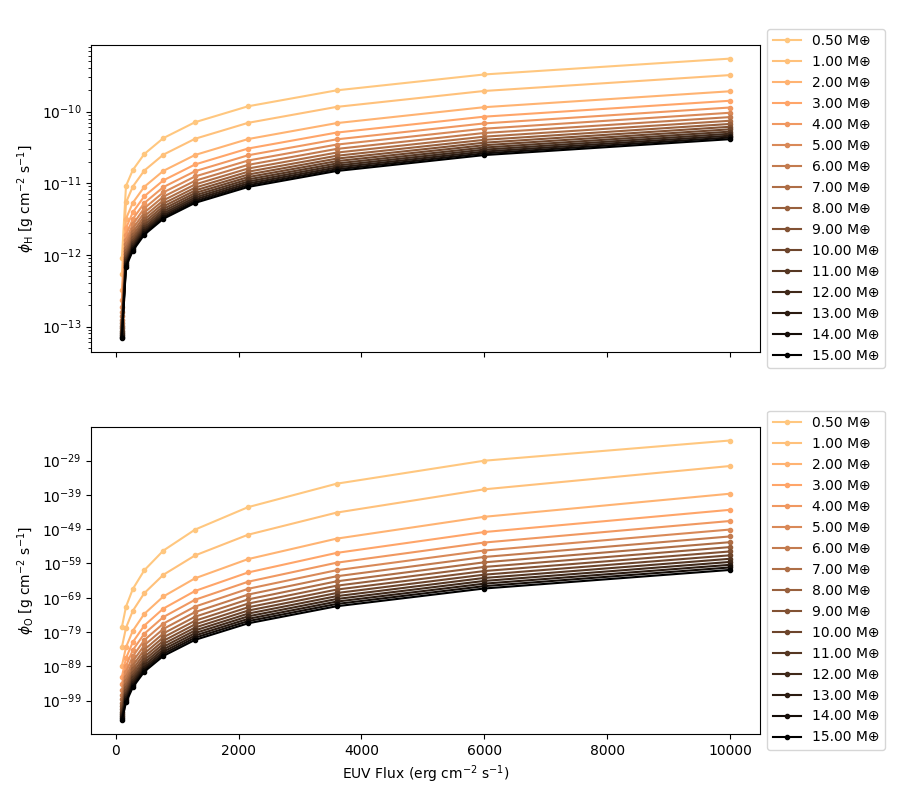

In [3]:
def main():

    # ---------- Initialize parameters and classes ----------
    params = ModelParams()
    mass_loss = MassLoss(params)
    fractionation = Fractionation(params)
    fractionation_multi = Fractionation_H_O_CO2(params)
    misc = Misc(params)

    # ---------- Load data ----------
    ### option 1
    base_path = '/Users/mvalatsou/PhD/Repos/MR_perplex/OUTPUT/CW/critical_WMF/gridmin295/'
    data_loader = ModelDataLoader(base_path)
    m_planet = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    water_percent = [x / 10 for x in range(1, 81)]
    radius, mass, Teq = data_loader.load_model_data(m_planet, water_percent)
    
    ### option 2
    # with open("planet_params.json", "r") as file:
    #     planet_params = json.load(file)
    # selected_planet = "TOI-431 b" # change the planet here

    # if selected_planet in planet_params:
    #     new_feuv = planet_params[selected_planet]["FEUV"]
    #     params.update_param("FEUV", new_feuv)
    #     print(f"Updated FEUV for {selected_planet}: {params.get_param('FEUV'):.2e} erg cm-2 s-1")
    # else:
    #     print(f"Make sure the planet you selected exists in the list! Check the spelling.")

    # mearth = params.mearth
    # rearth = params.rearth
    # radius = [planet_params[selected_planet]["radius"] * rearth] # cm
    # mass = [planet_params[selected_planet]["mass"] * mearth] # g
    # Teq = [planet_params[selected_planet]["teq"]] # K

    ### option 3
    # radius = 1 # cm
    # mass = 1 # g
    # Teq = 1 # K

    # ---------- Range of EUV flux values ----------
    ### option 1
    flux_values = [100, 450, 800, 1000, 5000]

    ### option 2
    start_log = np.log10(100)   # 2
    stop_log  = np.log10(10000) # 4
    step      = 0.25
    log_vals  = np.arange(start_log, stop_log + step, step)
    flux_values = 10 ** log_vals

    ### option 3
    flux_values = np.logspace(np.log10(100), np.log10(10000), 10)

    all_flux_results = []

    # ---------- Execute ----------
    for flux in flux_values:
        print(f"\n Running model with FEUV = {flux} erg/cm^2/s")
        params.update_param('FEUV', flux)

        # ---------- Mass loss model ----------
        mass_loss_results = mass_loss.compute_mass_loss_parameters(mass, radius, Teq)

        # ---------- Fractionation model ----------
        ### option 1 - without self consistent feedback loop
        # fractionation_results = fractionation.execute_fractionation(mass_loss_results, misc)
        
        ### option 2 - with feedback loop
        fractionation_results = fractionation.execute_self_consistent_fractionation(mass_loss_results, mass_loss, misc, params)

        ### option 3 - for H O CO2 system, with feedback loop (?)
        # fractionation_results = fractionation_multi.execute_self_consistent_fractionation(mass_loss_results, mass_loss, misc, params)

        results_for_this_flux = {'FEUV': flux, 'fractionation_results': fractionation_results}
        all_flux_results.append(results_for_this_flux)

    # ---------- Plot ----------
    # Across all EUV fluxes
    ResultsHandler.plot_phi_vs_m_planet_across_fluxes(all_flux_results)
    ResultsHandler.plot_phi_vs_flux_across_masses(all_flux_results)

    # Single EUV flux value results
    single_flux_data = all_flux_results[0] # pick a flux
    single_results_list = single_flux_data['fractionation_results']

    ResultsHandler.plot_radii_comparison(single_results_list)
    ResultsHandler.plot_cs_REUV(single_results_list)
    ResultsHandler.plot_combined_T_P(single_results_list)
    ResultsHandler.plot_phiH_phiO_vs_REUV(single_results_list)
    ResultsHandler.water_loss_over_time(single_results_list)

if __name__ == "__main__":
   main()